To begin copy this notebook to your own drive:

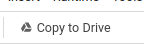


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Permission denied: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
Maybe you need to change permission over 'Anyone with the link'?


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Permission denied: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
Maybe you need to change permission over 'Anyone with the link'?


True

In [2]:
!pip install datasets
!pip install transformers

In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")
print(raw_datasets)

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [5]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-1deaf0e4869059b7.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b23cfeb68a931a8d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-65e05467bd5c4904.arrow


In [6]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [8]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [9]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.input_size = 300
          self.hidden_size = 300
          self.output_size = 2
          self.activation = nn.ReLU()
          self.input_layer = nn.Linear(self.input_size, self.hidden_size)
          self.hidden_layer = nn.Linear(self.hidden_size, self.hidden_size)
          self.output_layer = nn.Softmax()

          self.classifier = nn.Sequential(
              nn.Linear(self.input_size, self.hidden_size),

              # nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              
              # nn.Softmax()
              nn.Linear(self.hidden_size,self.output_size)
          )

          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      e = self.embeddings(input_ids)
      avg = torch.mean(e,1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [10]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size=50,
                                  per_device_eval_batch_size=50,
                                  learning_rate= 0.0005,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.526700,0.468842,0.780040
2,0.406900,0.398864,0.819840
3,0.391900,0.388496,0.825400
4,0.388000,0.456401,0.784520
5,0.388800,0.413913,0.809200
6,0.385200,0.389770,0.824240
7,0.374200,0.383652,0.828360
8,0.373700,0.377106,0.833480
9,0.371500,0.377440,0.834040
10,0.368300,0.394053,0.824000


TrainOutput(global_step=10000, training_loss=0.3765707260131836, metrics={'train_runtime': 565.8539, 'train_samples_per_second': 883.62, 'train_steps_per_second': 17.672, 'total_flos': 0.0, 'train_loss': 0.3765707260131836, 'epoch': 20.0})

# 5b



In [12]:
import matplotlib.pyplot as plt

def get_XY(trainer):
  hist = trainer.state.log_history

  epoch_eval = [(x["epoch"], x.get("eval_accuracy")) for x in hist if int(x["epoch"])==x["epoch"]]
  epoch_eval = [x for x in epoch_eval if x[1] is not None]

  epoch_eval = sorted(epoch_eval,key=lambda x:x[0])

  X = [x for x,y in epoch_eval]

  Y = [y*100 for x,y in epoch_eval]

  return X,Y
def plot_trainer(trainer, title):
  plt.clf()
  hist = trainer.state.log_history

  epoch_eval = [(x["epoch"], x.get("eval_accuracy")) for x in hist if int(x["epoch"])==x["epoch"]]
  epoch_eval = [x for x in epoch_eval if x[1] is not None]

  X = [x for x,y in epoch_eval]

  Y = [y*100 for x,y in epoch_eval]

  plt.plot(X,Y)

  plt.plot(X[-1],Y[-1],"or") # last point

  plt.axhline(y=Y[-1], color='r', linestyle='--') # last eval line

  plt.annotate(round(Y[-1],2),xy=(1,Y[-1]+0.05),color='red') #last eval annotate

  plt.title(title)
  plt.xlabel("epochs")
  plt.ylabel("eval accuracy %")

  plt.show()

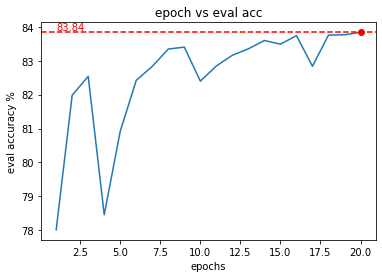

In [13]:
plot_trainer(trainer,'epoch vs eval acc')

In [14]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, dropout, layers, activation):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.input_size = 300
          self.hidden_size = 300
          self.output_size = 2
          self.dropout = dropout
          self.activation = activation
          
          if layers == 1:
            self.classifier = nn.Sequential(
                nn.Linear(self.input_size, self.hidden_size),

                # nn.Linear(self.hidden_size, self.hidden_size),
                self.activation(),

                nn.Linear(self.hidden_size,self.output_size)
            )
          elif layers == 2:
            self.classifier = nn.Sequential(
                nn.Linear(self.input_size, self.hidden_size),

                # nn.Linear(self.hidden_size, self.hidden_size),
                self.activation(),
                nn.Linear(self.hidden_size, self.hidden_size),
                self.activation(),

                nn.Linear(self.hidden_size,self.output_size)
            )
          elif layers == 3:
            self.classifier = nn.Sequential(
                nn.Linear(self.input_size, self.hidden_size),

                # nn.Linear(self.hidden_size, self.hidden_size),
                self.activation(),
                nn.Linear(self.hidden_size, self.hidden_size),
                self.activation(),
                nn.Linear(self.hidden_size, self.hidden_size),
                self.activation(),
                
                nn.Linear(self.hidden_size,self.output_size)
            )
          else:
            self.classifier = nn.Sequential(
                nn.Linear(self.input_size, self.output_size)
            )

          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      d = nn.Dropout(p=self.dropout)
      e = self.embeddings(input_ids)
      e = d(e)
      avg = torch.mean(e,1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [15]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
def train_model(dropout=0, layers=3, activation=nn.ReLU, epochs=20, t_batch=50, e_batch=50, learning_rate=0.0005):
  co = DataCollatorWithPadding()
  training_args = TrainingArguments("DAN",
                                    # YOUR CODE HERE
                                    num_train_epochs= epochs, #must be at least 10.
                                    per_device_train_batch_size=t_batch,
                                    per_device_eval_batch_size=e_batch,
                                    learning_rate= learning_rate,
                                    # END YOUR END
                                    
                                    save_total_limit=2,
                                    log_level="error",
                                    evaluation_strategy="epoch")
  model = DAN(dropout, layers, activation)

      

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE

                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )

  trainer.train()
  
  return trainer


#5b

In [16]:
X = []
Y = []
ts = []
for i in range(0,5):
  dropout = i*0.05
  t = train_model(dropout=dropout)
  ts.append(t)
  acc = get_XY(t)[1][-1]
  X.append(dropout)
  Y.append(acc)
  print(f"========================\nfinished {dropout}\n========================")


{'loss': 0.5259, 'learning_rate': 0.000475, 'epoch': 1.0}
{'eval_loss': 0.4279170334339142, 'eval_accuracy': 0.80828, 'eval_runtime': 11.9268, 'eval_samples_per_second': 2096.122, 'eval_steps_per_second': 41.922, 'epoch': 1.0}
{'loss': 0.4068, 'learning_rate': 0.00045000000000000004, 'epoch': 2.0}
{'eval_loss': 0.3903854191303253, 'eval_accuracy': 0.8252, 'eval_runtime': 11.9882, 'eval_samples_per_second': 2085.381, 'eval_steps_per_second': 41.708, 'epoch': 2.0}
{'loss': 0.3936, 'learning_rate': 0.000425, 'epoch': 3.0}
{'eval_loss': 0.3834010660648346, 'eval_accuracy': 0.82864, 'eval_runtime': 11.8981, 'eval_samples_per_second': 2101.182, 'eval_steps_per_second': 42.024, 'epoch': 3.0}
{'loss': 0.3906, 'learning_rate': 0.0004, 'epoch': 4.0}
{'eval_loss': 0.46471020579338074, 'eval_accuracy': 0.77984, 'eval_runtime': 11.7576, 'eval_samples_per_second': 2126.277, 'eval_steps_per_second': 42.526, 'epoch': 4.0}
{'loss': 0.3882, 'learning_rate': 0.000375, 'epoch': 5.0}
{'eval_loss': 0.413396

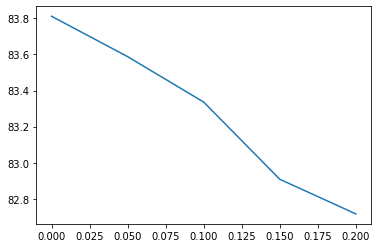

In [17]:
plt.clf()
plt.plot(X,Y)
plt.show()

# 5c

In [ ]:
X = []
Y = []
tsl = []
for l in range(0,4):
  t = train_model(layers=l)
  tsl.append(t)
  acc = get_XY(t)[1][-1]
  X.append(l)
  Y.append(acc)
  print(f"========================\nfinished {l}\n========================")

{'loss': 0.6827, 'learning_rate': 0.000475, 'epoch': 1.0}
{'eval_loss': 0.6739585995674133, 'eval_accuracy': 0.64844, 'eval_runtime': 11.8621, 'eval_samples_per_second': 2107.552, 'eval_steps_per_second': 42.151, 'epoch': 1.0}
{'loss': 0.665, 'learning_rate': 0.00045000000000000004, 'epoch': 2.0}
{'eval_loss': 0.6605799198150635, 'eval_accuracy': 0.65804, 'eval_runtime': 11.8983, 'eval_samples_per_second': 2101.138, 'eval_steps_per_second': 42.023, 'epoch': 2.0}
{'loss': 0.6526, 'learning_rate': 0.000425, 'epoch': 3.0}
{'eval_loss': 0.6505511999130249, 'eval_accuracy': 0.6686, 'eval_runtime': 11.6953, 'eval_samples_per_second': 2137.612, 'eval_steps_per_second': 42.752, 'epoch': 3.0}
{'loss': 0.6431, 'learning_rate': 0.0004, 'epoch': 4.0}
{'eval_loss': 0.6426485776901245, 'eval_accuracy': 0.67676, 'eval_runtime': 11.9854, 'eval_samples_per_second': 2085.864, 'eval_steps_per_second': 41.717, 'epoch': 4.0}
{'loss': 0.6358, 'learning_rate': 0.000375, 'epoch': 5.0}
{'eval_loss': 0.63611525

In [ ]:
plt.clf()
plt.plot(X,Y)
plt.show()

# 5d

In [ ]:
X = [nn.ReLU, nn.Sigmoid, nn.Tanh]
Y = []
tsl = []
for act in X:
  t = train_model(activation=act)
  tsl.append(t)
  acc = get_XY(t)[1][-1]
  Y.append(acc)
  print(f"========================\nfinished{act}\n========================")

In [ ]:
for t,title in zip(tsl,['ReLU','Sigmoid',r'$tanh$']):
  plot_trainer(t,title)